/tmp/ipykernel_3582151/3588684171.py:129: RuntimeWarning: invalid value encountered in true_divide
  y=data_view/total_bkg_view,
/tmp/ipykernel_3582151/3588684171.py:130: RuntimeWarning: invalid value encountered in true_divide
  yerr=np.sqrt(total_bkg_view)/total_bkg_view,#ratio_uncertainty(data_view, total_bkg_view, "poisson"),
/tmp/ipykernel_3582151/3588684171.py:138: RuntimeWarning: invalid value encountered in true_divide
  baseline=1 - (data_view/total_bkg_view**2)*np.sqrt(total_bkg_view),
/tmp/ipykernel_3582151/3588684171.py:139: RuntimeWarning: invalid value encountered in true_divide
  values=1 + (data_view/total_bkg_view**2)*np.sqrt(total_bkg_view),


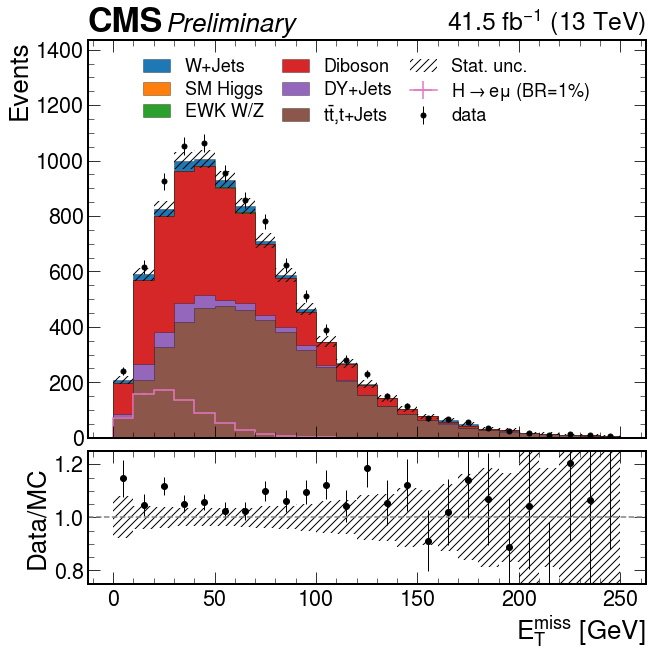

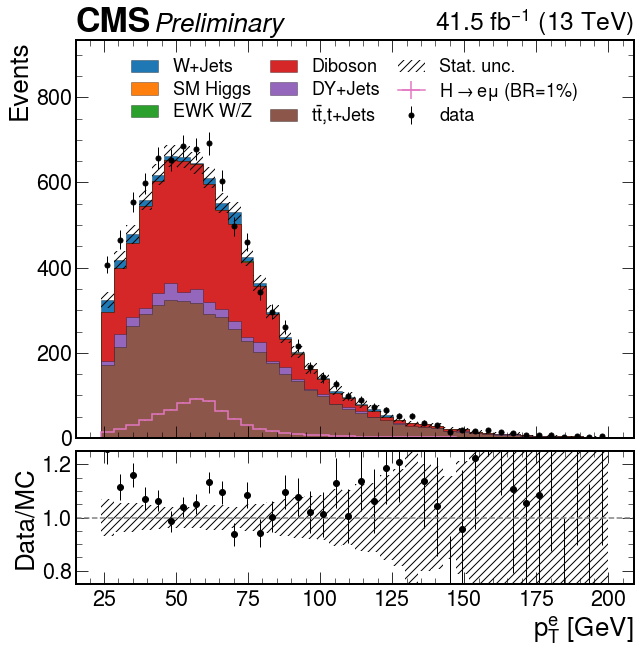

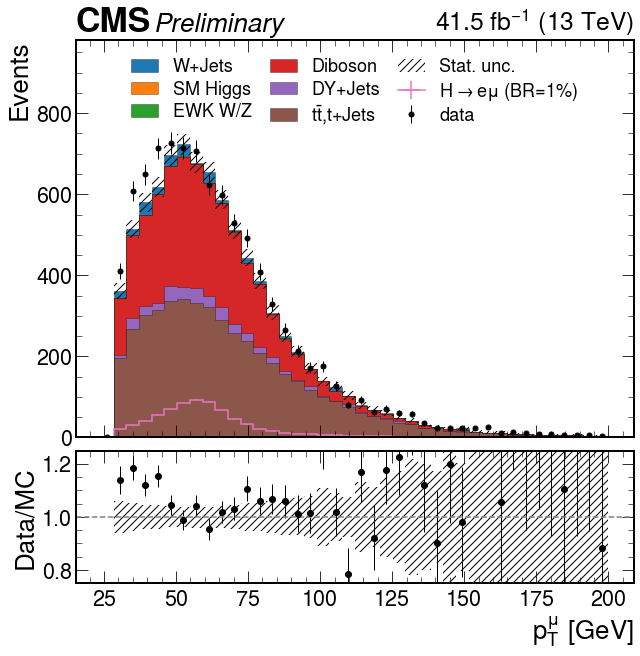

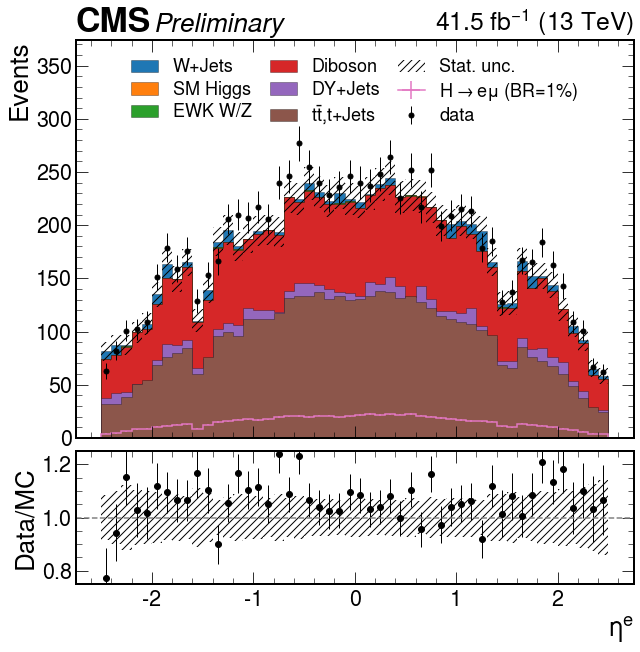

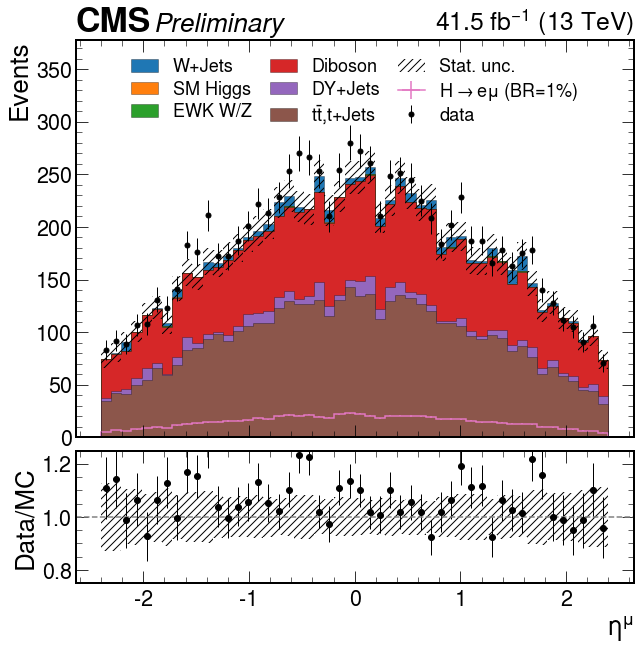

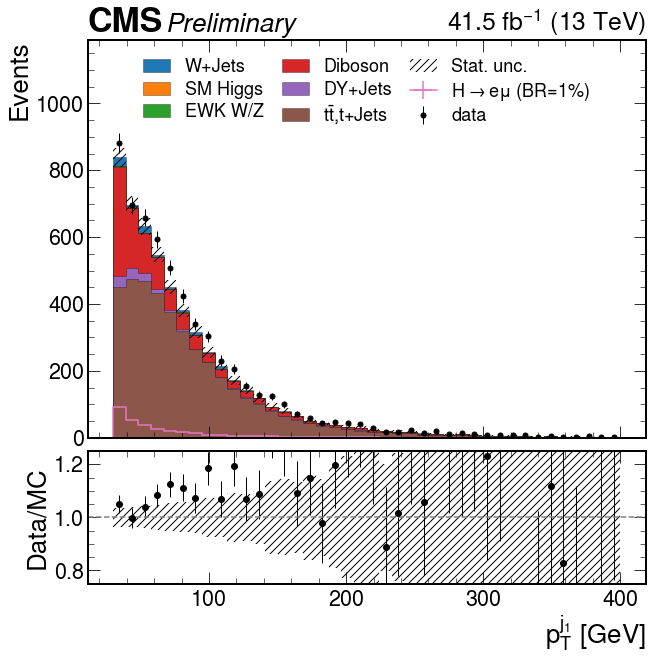

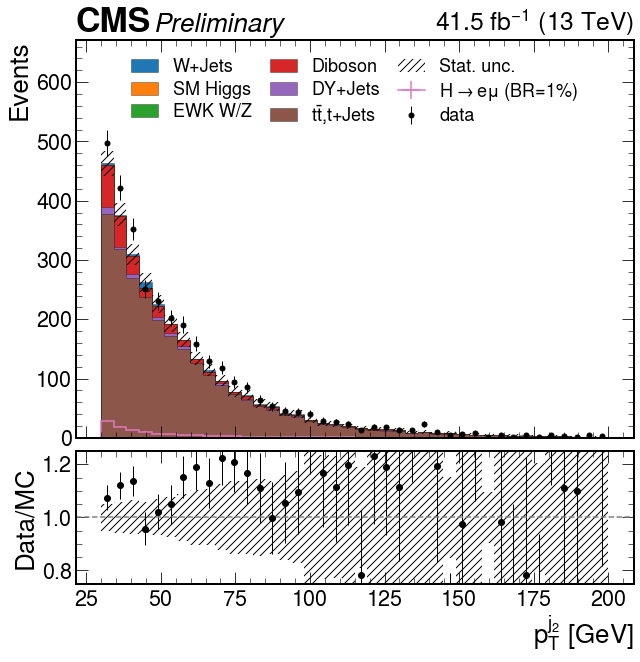

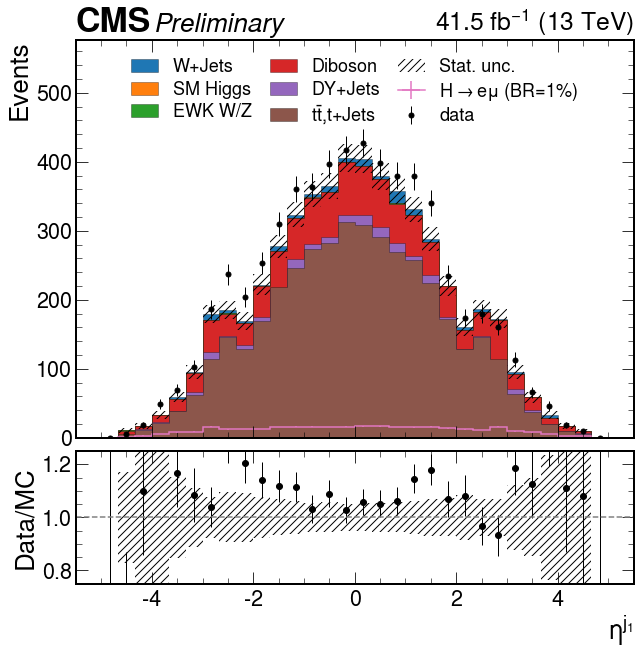

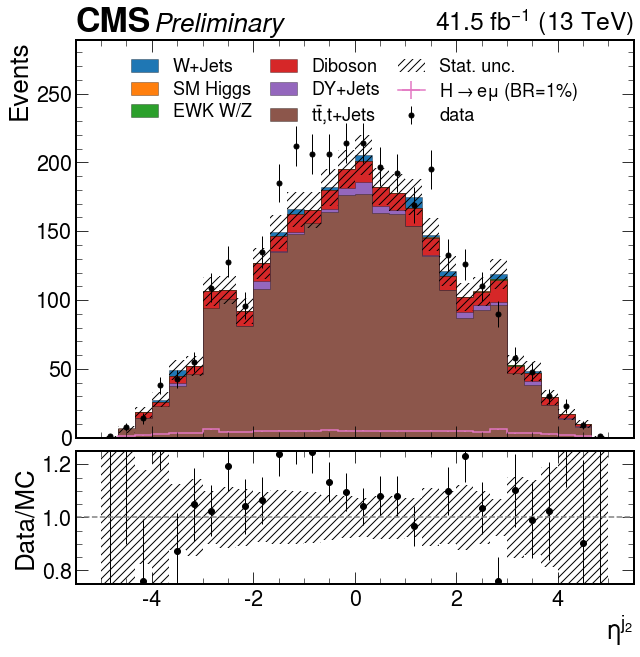

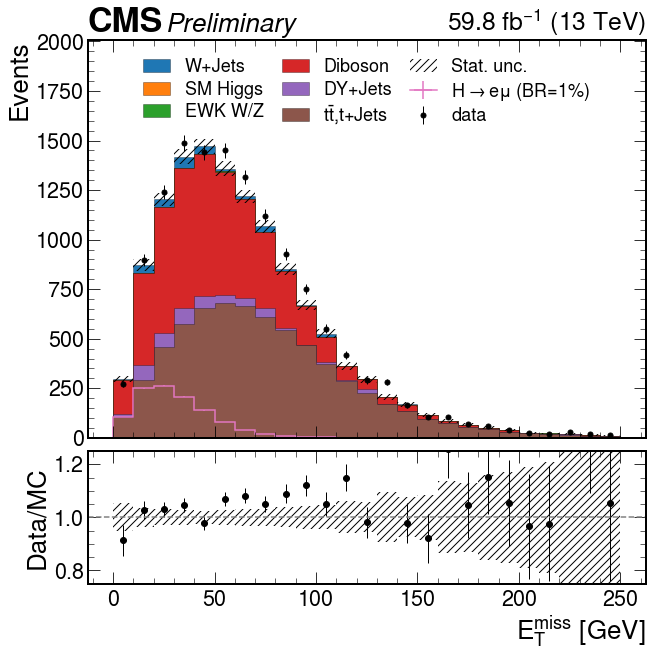

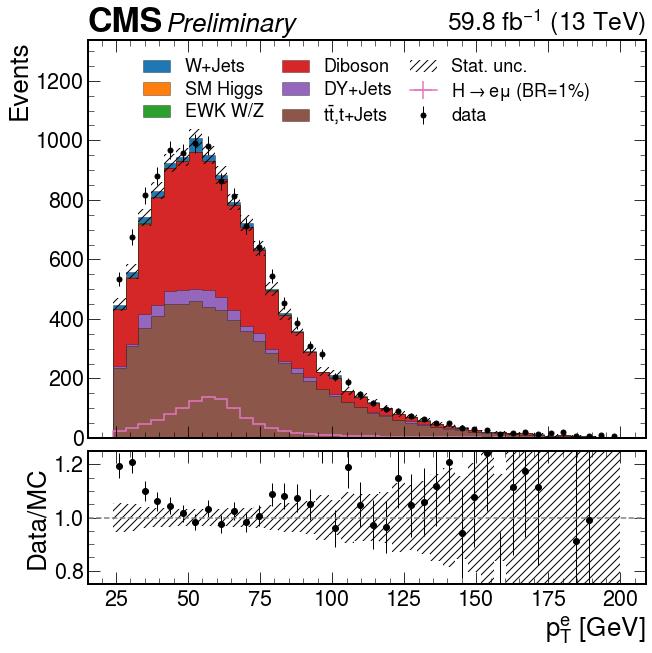

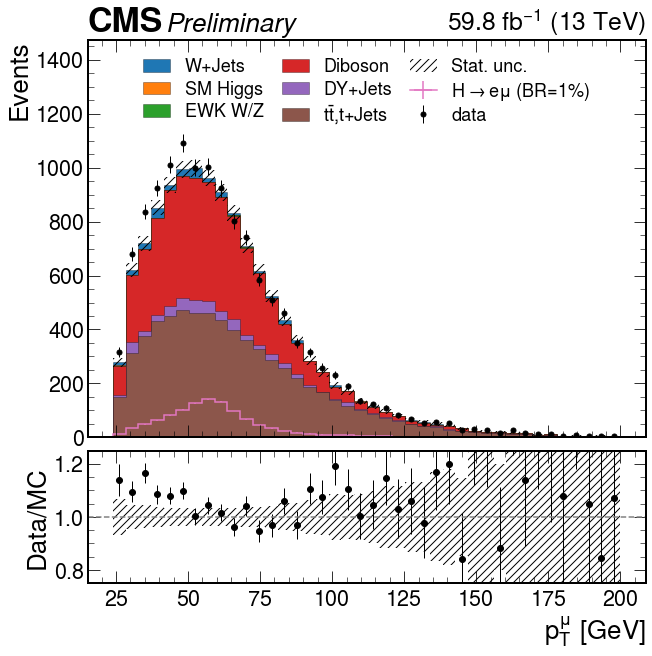

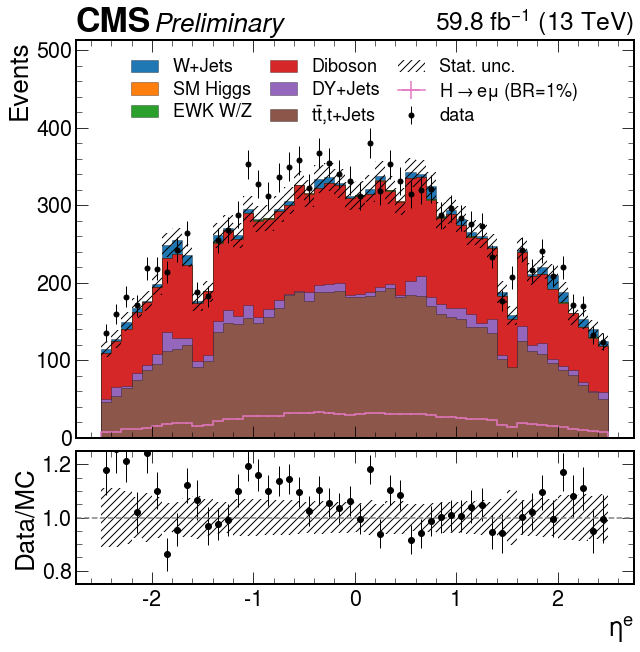

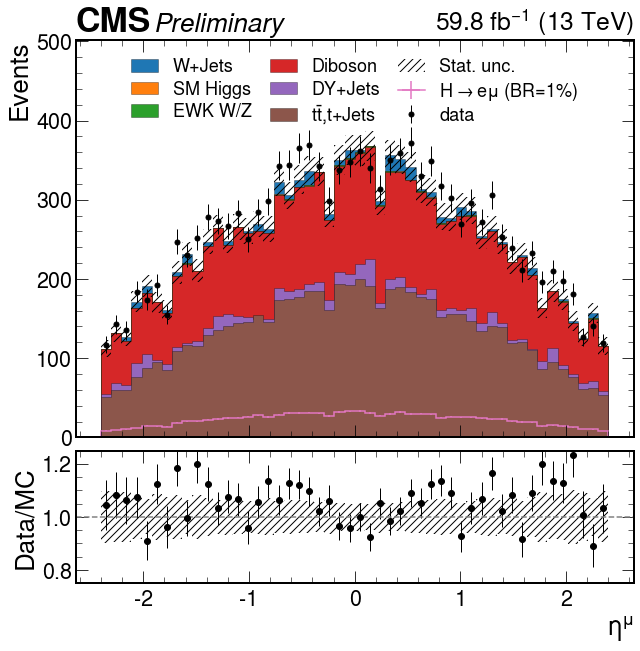

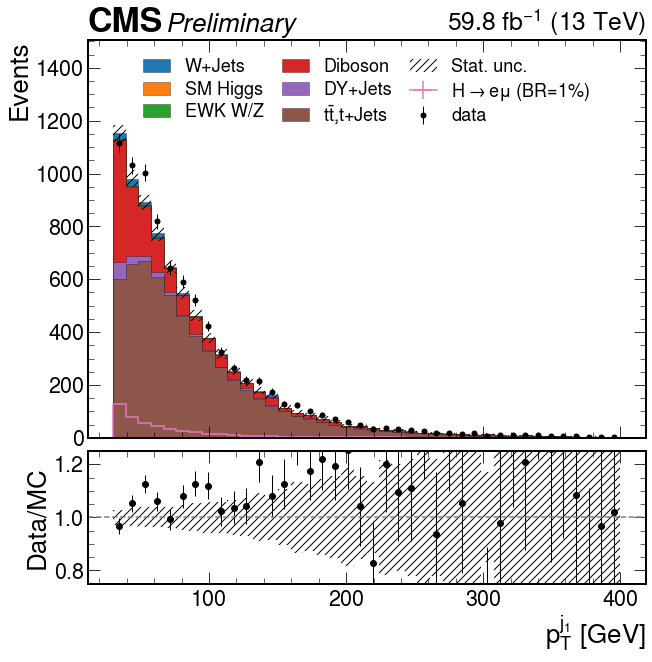

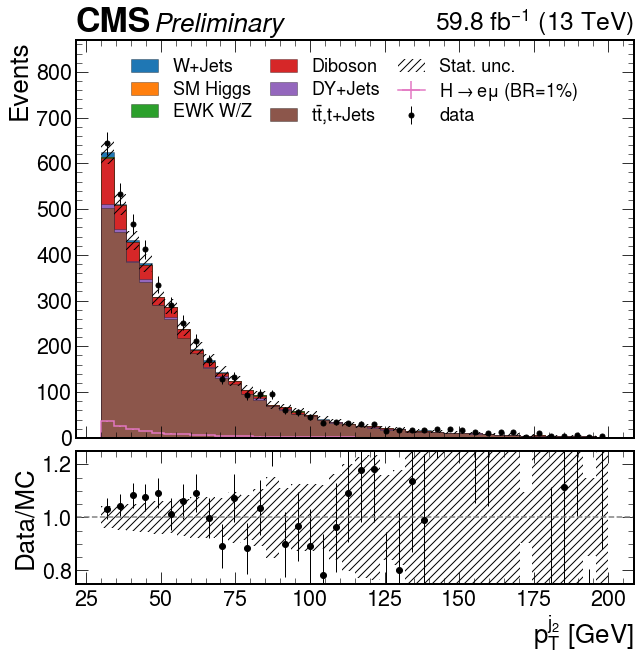

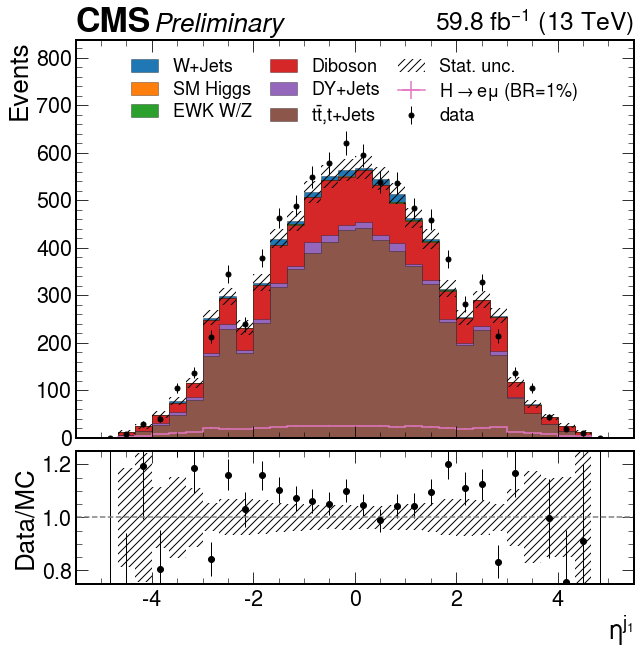

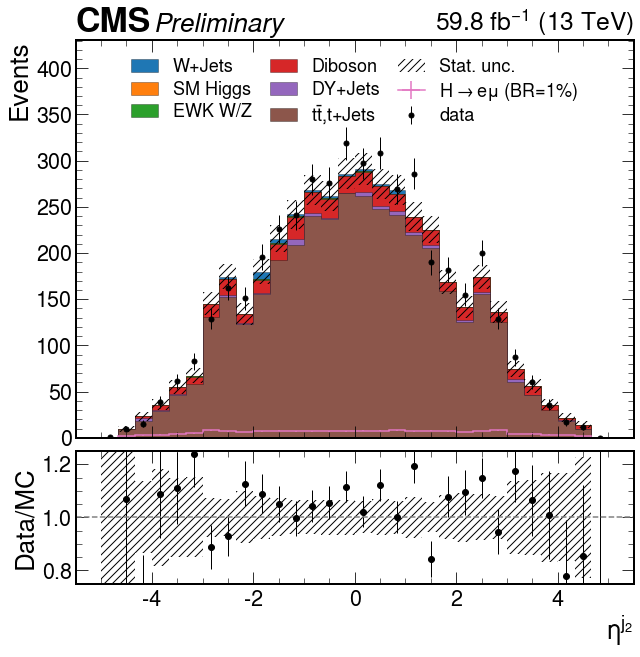

In [25]:
from coffea.util import save, load
from coffea import hist

years = ['2017','2018']
datalumis = {'2016preVFP': 36.3, '2016postVFP': 36.3, '2017': 41.5, '2018': 59.8}

%matplotlib inline

for year in years:
    histo_dict = load(f"../results/{year}/makeHist/output_btagM_v2.coffea")[0]

    list_of_bkg = [r'$t\bar{t}$,t+Jets', 'SM Higgs', "DY+Jets", "EWK W/Z", "Diboson", "W+Jets"]
    lis_of_vars = ['MET', 'ePt', 'mPt', 'eEta', 'mEta', 'j1Pt', 'j2Pt', 'j1Eta', 'j2Eta']

    xlabel_dict = {
        "$\eta^{j_{1}}$"
    }

    label_dict = {
        'data': 'data',
        'TTTo2L2Nu': r'$t\bar{t}$',
        'GluGlu_LFV_HToEMu_M125': r'$H\rightarrow e\mu$ (BR=1%)',
        'DYJetsToLL_M-50': r'DY+Jets',
        "Stat. unc.": "Stat. unc."
    }

    for var_ in lis_of_vars:
        histo = histo_dict[var_]
        scales = {
            r'$H\rightarrow e\mu$ (BR=1%)': 0.1,
        }
        histo.scale(scales, axis='dataset')

        data = histo[['data'], :].to_hist()
        bkg = histo[list_of_bkg, :].to_hist()
        signal = histo[[r'$H\rightarrow e\mu$ (BR=1%)'], :].to_hist()

        import matplotlib.pyplot as plt
        import mplhep
        plt.style.use(mplhep.style.CMS)

        # define a ratio plot figure
        fig, (ax, rax) = plt.subplots(2, 1, gridspec_kw=dict(height_ratios=[3, 1], hspace=0.05), sharex=True)
        #fig, ax = plt.subplots()

    #     from cycler import cycler
    #     colors = ['#1f78b4','#33a02c','#e31a1c']
    #     ax.set_prop_cycle(cycler(color=colors))

        bkg.plot1d(
            ax=ax,
            overlay="dataset",
            histtype="fill",
            stack=True,
            #alpha=0.5,
            edgecolor=(0, 0, 0, 0.3),
        )

        signal.plot1d(
            ax=ax,
            overlay="dataset",
            #histtype="fill",
            #stack=True,
            #alpha=0.5,
            #edgecolor=(0, 0, 0, 0.3),
            #label=r'$H\rightarrow e + \mu$'
        )

        data.plot1d(ax=ax, histtype="errorbar", color="k")

        total_bkg_view = bkg[::sum, :].to_numpy()[0]

        total_trig_unc = total_bkg_view*0.02
        total_ele_unc = total_bkg_view*0.02
        total_mu_unc = total_bkg_view*0.02
        total_lumi_unc = total_bkg_view*0.023
        total_tt_unc = histo[r'$t\bar{t}$,t+Jets', :].to_hist()[::sum, :].to_numpy()[0]*0.06
        total_SM_unc = 0#np.sqrt(histo['SM Higgs', :].to_hist()[::sum, :].to_numpy()[0])
        total_DY_unc = histo["DY+Jets", :].to_hist()[::sum, :].to_numpy()[0]*0.04
        total_EWK_unc = histo["EWK W/Z", :].to_hist()[::sum, :].to_numpy()[0]*0.04
        total_DB_unc = histo["Diboson", :].to_hist()[::sum, :].to_numpy()[0]*0.05
        total_WJ_unc = 0#np.sqrt(histo["W+Jets", :].to_hist()[::sum, :].to_numpy()[0])

        total_unc = total_trig_unc+total_ele_unc+total_mu_unc+total_lumi_unc\
                    +total_tt_unc+total_SM_unc+total_DY_unc+total_EWK_unc+total_DB_unc+total_WJ_unc

        data_view = data[::sum, :].to_numpy()[0]

        xlabel = ax.get_xlabel()
        ax.set_xlabel("")
        ax.set_ylabel("Events")
        ax.set_ylim(0, max(data_view)*1.35)

        import numpy as np

        # create a total statistical uncertainty hatch
        ax.stairs(
            edges=bkg.axes[1].edges,
            baseline=total_bkg_view - np.sqrt(total_bkg_view),
            values=total_bkg_view + np.sqrt(total_bkg_view),
            hatch="///",
            label="Stat. unc.",
            facecolor="none",
            linewidth=0,
            color="black",
        )

        label_list = []
        for t in ax.get_legend_handles_labels():
            label_list.append(t)
        new_label_list = []
        for txt in label_list[1]:
            if txt[0] == '0':
                txt = str(txt)[:4]
            if txt==r'$H\rightarrow e\mu$ (BR=1%)':
                new_label_list.append(r'$H\rightarrow e\mu$ (BR=0.1%)')
            else:
                new_label_list.append(txt)
        label_list[1] = new_label_list

        ax.legend(handles=label_list[0], labels=label_list[1])
        legend = ax.legend(fontsize='x-small', ncol=3, columnspacing=1, labelspacing=0.25, loc=9)

        # now draw a ratio plot
        from hist.intervals import ratio_uncertainty

        rax.errorbar(
            x=data.axes[1].centers,
            y=data_view/total_bkg_view,
            yerr=np.sqrt(total_bkg_view)/total_bkg_view,#ratio_uncertainty(data_view, total_bkg_view, "poisson"),
            color="k",
            linestyle="none",
            marker="o",
            elinewidth=1,
        )
        rax.stairs(
            edges=bkg.axes[1].edges,
            baseline=1 - (data_view/total_bkg_view**2)*np.sqrt(total_bkg_view),
            values=1 + (data_view/total_bkg_view**2)*np.sqrt(total_bkg_view),
            hatch="///",
            label="Stat. unc.",
            facecolor="none",
            linewidth=0,
            color="black",
        )
        rax.axhline(y=1.0, linestyle="dashed", color="gray")
        rax.set_ylabel("Data/MC", loc="center")
        rax.set_ylim(0.75, 1.25)
        rax.set_xlabel(f"{xlabel}")

        # add some labels
        lumi = mplhep.cms.label(ax=ax, lumi=datalumis[year], label="Preliminary", data=1)